# Recommendations with IBM

In this notebook, using data from the IBM Watson Studio platform, I built out several different methods for making recommendations for different situations. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Concluding](#conclusions)

importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Showing df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Showing df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">I : Exploratory Data Analysis</a>

Providing some insight into the descriptive statistics of the data.

#### What is the distribution of how many articles a user interacts with in the dataset?

Descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
print(df["email"].value_counts().describe())

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64


Visual statistics to assist with giving a look at the number of times each user interacts with an article.  

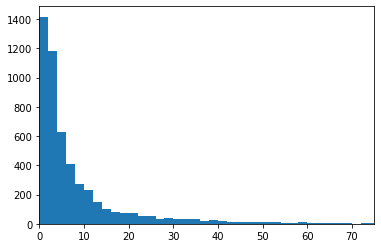

In [4]:
bins = np.arange(0, df["email"].value_counts()[0]+2, 2)
plt.hist(df["email"].value_counts(), bins=bins);
plt.xlim((0, 75));

In [5]:
median_val = int(df["email"].value_counts().median())
max_views_by_user = int(df["email"].value_counts().max()) 
print('50% of individuals interact with {} number of articles or fewer'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.


#### Exploring and removing duplicate articles from the **df_content** dataframe.  

In [6]:
# Finding and exploring duplicate articles
df_content[df_content["article_id"].duplicated(keep="first")]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [7]:
# Removing any rows that have the same article_id - only keeping the first
print('# of rows before removing duplicates:', df_content.shape[0])
df_content.drop_duplicates("article_id", inplace=True)
print('# of rows after removing duplicates:', df_content.shape[0])

# of rows before removing duplicates: 1056
# of rows after removing duplicates: 1051


In [8]:
df_uniq = df.drop_duplicates(inplace=False)
unique_articles = len(pd.unique(df_uniq["article_id"])) 
print('The number of unique articles that have at least one interaction:', unique_articles)
total_articles = len(pd.unique(df_content["article_id"]))
print('The number of unique articles on the IBM platform (whether they have any interactions or not):', total_articles)
unique_users = len(pd.unique(df['email'].dropna()))
print('The number of unique users in the dataset is {} (excluding null values)'.format(unique_users))
user_article_interactions = len(df)
print('The total number of user-article interactions in the dataset is:', user_article_interactions)

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform (whether they have any interactions or not): 1051
The number of unique users in the dataset is 5148 (excluding null values)
The total number of user-article interactions in the dataset is: 45993


In [9]:
most_viewed_article_id = str(df["article_id"].value_counts().index[0])  
max_views = int(df["article_id"].value_counts().iloc[0])
print('The article_id of the most viewed article is:', most_viewed_article_id)
print('The most viewed article in the dataset was viewed {} times.'.format(max_views))

The article_id of the most viewed article is: 1429.0
The most viewed article in the dataset was viewed 937 times.


In [10]:
most_viewed_by_diff_usrs_article_id = df_uniq["article_id"].value_counts().index[0]
max_usrs = int(df_uniq["article_id"].value_counts().iloc[0])
print("The most viewed article_id by different users in the dataset was:", most_viewed_by_diff_usrs_article_id) 
print("The most viewed article by different users in the dataset was viewed by {} users".format(max_usrs))

The most viewed article_id by different users in the dataset was: 1330.0
The most viewed article by different users in the dataset was viewed by 467 users


In [11]:
# Mapping the user email to a user_id column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()

# Removing the email column
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">II: Rank-Based Recommendations</a>

We only know whether a user has interacted with an article or not. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    Description:
    Return the n top article titles ordered with most interactions as the top
    '''
    top_articles = list(df["title"].value_counts().index)[:n]
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    Description:
    Return the n top article_ids titles ordered with most interactions as the top
    '''
    top_articles = list(map(str, df["article_id"].value_counts().index))[:n]
 
    return top_articles # Return the top article ids

In [13]:
# Testing the function by returning the top 5 articles
print(get_top_articles(5))
print(get_top_article_ids(5))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']


### <a class="anchor" id="User-User">III: User-User Based Collaborative Filtering</a>


#### Reformating the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appears in each **row** once.
  
  
* Each **article** only shows up in one **column**.  
  
  
* **If a user has interacted with an article, 1 is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article are 1.  
  
  
* **If a user has not interacted with an item, zero is placed where the user-row meets for that article-column**. 

In [14]:
# Creating the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = pd.crosstab(df['user_id'], df['article_id'])
    user_item[user_item > 1] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [15]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_dic = {}
    for index, row in user_item.iterrows():
        similarity_dic[index] = np.dot(user_item.loc[user_id, :], row)

    # sort by similarity
    similarity_dic = {k: v for k, v in sorted(similarity_dic.items(), key=lambda item: item[1], reverse=True)}

    # create list of just the ids
    most_similar_users = list(similarity_dic.keys())

    # remove the own user's id
    most_similar_users.remove(user_id)   

    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
# Checking the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


#### Using these users to find articles to recommend.

In [17]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    for i in range(0, len(article_ids)):
        article_ids[i] = float(article_ids[i])
    
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    usr_art = user_item.loc[user_id, :]
    article_ids = list(usr_art[usr_art>0].index.map(str))
    
    get_article_names_input = list(usr_art[usr_art>0].index.map(str))
    article_names = get_article_names(get_article_names_input)

    return article_ids, article_names # return the ids and names

from collections import OrderedDict
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []

    ids_usr, names = get_user_articles(user_id)

    similar_users = find_similar_users(user_id)

    n = 0
    for usr in similar_users:
        ids, names = get_user_articles(usr)
        articles_not_seen = np.setdiff1d(ids_usr, ids, assume_unique=True).tolist()
        recs += articles_not_seen
        recs = list(OrderedDict.fromkeys(recs))
        # If there are more than 
        if len(recs) >= m:
            break 
        
    recs = recs[:m]
                
    return recs # return your recommendations for this user_id    

In [18]:
user_user_recs(1, 10)

['151.0',
 '268.0',
 '310.0',
 '329.0',
 '346.0',
 '390.0',
 '494.0',
 '525.0',
 '585.0',
 '626.0']

In [19]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze db2 warehouse on cloud data in rstudio in dsx',
 'introduction to market basket analysis in\xa0python',
 'jupyter notebook tutorial',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'sector correlations shiny app',
 'python for loops explained (python for data science basics #5)',
 'introducing ibm watson studio ',
 'time series prediction using recurrent neural networks (lstms)']

In [20]:
# Testing the functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])

#### Improving the consistency of the **user_user_recs** function.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choosing the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choosing articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [21]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity_dic = {}
    for index, row in user_item.iterrows():
        similarity_dic[index] = np.dot(user_item.loc[user_id, :], row)

    # sort by similarity
    similarity_dic = {k: v for k, v in sorted(similarity_dic.items(), key=lambda item: item[1], reverse=True)}

    # remove the own user's id
    similarity_dic.pop(user_id)

    # create list of just the neighbor user_id
    neighbor_id = list(similarity_dic.keys())

    # create list of just the measure of the similarity of each user to the provided user_id
    similarity = list(similarity_dic.values())
    
    num_interactions = []
    for neighbor in neighbor_id:
        num_interactions.append(user_item.loc[neighbor, :].sum())
        
    neighbors_df = pd.DataFrame(
        {'neighbor_id': neighbor_id,
         'similarity': similarity,
         'num_interactions': num_interactions
        })
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = [] # (list) a list of recommendations for the user by article id
    rec_names = [] # (list) a list of recommendations for the user by article title
    order = list(df["article_id"].value_counts().index.map(str))
    top = get_top_article_ids(m)

    ids_usr, names = get_user_articles(user_id)

    neighbors_df = get_top_sorted_users(user_id)

    n = 0
    # Loops through the users based on closeness to the input user_id
    for usr in neighbors_df['neighbor_id']:
        # For each user - finds articles the user hasn't seen before and provides them as recs
        ids, names = get_user_articles(usr)
        rec = list(set(ids_usr) - set(ids))
        # Choose articles with the articles with the most total interactions before choosing those with fewer total interactions
        rec = [r for r in order if r in rec] 
        for r in rec:
            # Does this until m recommendations are found
            if n<m:
                recs.append(r) # (list) a list of recommendations for the user by article id
                n+=1
            else:
                break
                
    recs = list(dict.fromkeys(recs))
    
    if len(recs) < m:
        top_notin_recs = [t for t in top if t not in recs]
        n_add = m - len(recs)
        recs.extend(top_notin_recs[:n_add])
    
    rec_names = get_article_names(recs) # (list) a list of recommendations for the user by article title
                
    return recs, rec_names

In [22]:
# Testing the functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[844.0, 232.0, 1320.0, 1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'housing (2015): united states demographic measures', 'finding optimal locations of new store using decision optimization', 'self-service data preparation with ibm data refinery', 'predicting churn with the spss random tree algorithm', 'use the cloudant-spark connector in python notebook']


In [23]:
# Testing results
user1_most_sim = get_top_sorted_users(1)['neighbor_id'][0]
print('The user that is most similar to user 1 is:', user1_most_sim)

user131_10th_sim = get_top_sorted_users(131)['neighbor_id'][9]
print('The user that is the 10th most similar to user 131 is:', user131_10th_sim)

The user that is most similar to user 1 is: 3933
The user that is the 10th most similar to user 131 is: 242


#### If we were given a new user, we use the get_top_article_ids() function defined earlier to make recommendations as these are rank-based functions. We only know whether a user has interacted with an article or not. In these cases, the recommendation of an article for a new user can be based on how often an article was interacted with. Another possible better method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. 

#### We will not be able to use the functions developed in User-User Based Collaborative Filtering since a new user has not had any form of interaction with our content and as a result, the dot product of new users with any other user will be 0.

In [24]:
new_user = '0.0'

# As they have no observed articles. Our top 10 article ids recommendations be for this new user '0.0' would be
new_user_recs = get_top_article_ids(10)
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

### <a class="anchor" id="Matrix-Fact">IV: Matrix Factorization</a>

Using matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [25]:
# Loading the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [26]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Using Singular Value Decomposition from numpy on the user-item matrix.

In [27]:
# Performing SVD on the User-Item Matrix

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

#### For this situation, we can use Singular Value Decomposition from numpy on the user-item matrix. This is the case because we are dealing with a matrix with all 1-0 values. The built-in works for this matrix, because it has no missing values, so there is no need to use FunkSVD

In [28]:
user_item_matrix.shape

(5149, 714)

In [29]:
u.shape

(5149, 5149)

In [30]:
s.shape

(714,)

In [31]:
vt.shape

(714, 714)

#### Choosing the number of latent features to use.

In [32]:
df.shape

(45993, 3)

In [33]:
# Spliting the dataset into a training and test set
df_train = df.head(40000)
df_test = df.tail(5993)

In [34]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids 
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_test = create_user_item_matrix(df_test)
    user_item_test = user_test[user_test.index.isin(list(user_item_train.index))]
    
    # Finding the subset of rows in the user_item_test dataset that can be used to predict using the matrix 
    # decomposition with different numbers of latent features to see how many features makes sense to keep based 
    # on the accuracy on the test data. 

    user_item_train_idx = list(user_item_train.index)
    test_idx = []
    for idx in list(user_test.index):
        if idx in user_item_train_idx:
            test_idx.append(user_item_train_idx.index(idx))

    user_item_train_cols = list(user_item_train.columns)
    test_arts = []
    for col in list(user_test.columns):
        if col in user_item_train_cols:
            test_arts.append(user_item_train_cols.index(col))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
print('The number of users we can make predictions for in the test set is:', user_item_test.shape[0])
print('The number of users in the test set we are not able to make predictions because of the cold start problem is:', 
      len(test_idx) - user_item_test.shape[0])
print('The number of articles we can make predictions for in the test set is:', len(test_arts))
print('The number of articles in the test set we are not able to make predictions for because of the cold start problem is', 
      len(test_arts) - user_item_test.shape[1])

The number of users we can make predictions for in the test set is: 20
The number of users in the test set we are not able to make predictions because of the cold start problem is: 0
The number of articles we can make predictions for in the test set is: 574
The number of articles in the test set we are not able to make predictions for because of the cold start problem is 0


#### Finding U, S, and V transpose using SVD on the user_item_train dataset

In [36]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

#### Exploring how well SVD works towards making predictions for recommendations on the test data. 

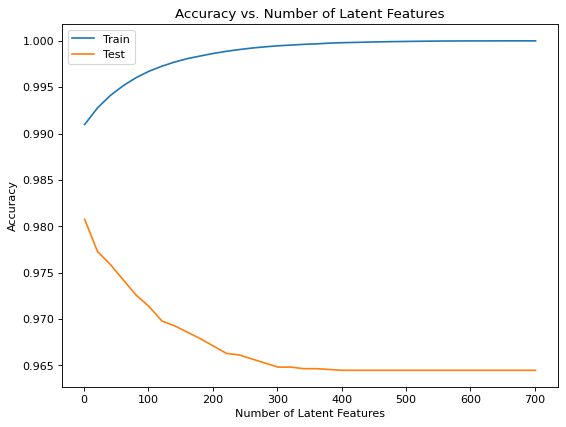

In [37]:
num_latent_feats = np.arange(1,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
        
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    user_item_est_train_slice = user_item_est_train[np.ix_(test_idx, test_arts)]

    diffs_test = np.subtract(user_item_test, user_item_est_train_slice)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train) / (user_item_train.shape[0] * user_item_train.shape[1]), label="Train");
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test) / (user_item_test.shape[0] * user_item_test.shape[1]), label="Test");

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

<a id='conclusions'></a>

#### As the number of latent features increases, we obtain a higher error rate on the test set predictions. This is beacause of the small test test (There were only 20 individuals who co-existed between the training and testing data-sets), not even enough data to get an idea about the optimal number of latent features. This a common situation during initial prototype of recommendation engines, since there is the cold start problem with a lot of users. Because of these reasons this model is not suitable for use in production yet.

#### We can proceed by conducting A/B tests to determine the impacts of implementing various recommendation systems into the user base. Users will reveice additional unseen articles and we can use as a metric the number of articles read per recommended articles per user. After collecting 100 interactions per recommendation system we can then choose the model that achive a higher article read per recommended article per user.

In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1